In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 1184, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1184 (delta 22), reused 5 (delta 3), pack-reused 1151
Receiving objects: 100% (1184/1184), 15.01 MiB | 14.87 MiB/s, done.
Resolving deltas: 100% (852/852), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 17.9 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/xgboost/__results__.html
/kaggle/input/xgboost/__notebook__.ipynb
/kaggle/input/xgboost/__output__.json
/kaggle/input/xgboost/custom.css
/kaggle/input/xgboost/__results___files/__results___30_1.png


In [5]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [6]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [7]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [8]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [9]:
config = {
    'tune_parameters': True,
    'n_trials': 100,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [12]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [13]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.25720011864882797, 'beta': 0.16040931258686913, 'topK': 33}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'False',
 'implicit': 'False',
 'alpha': 0.3185935970252052,
 'topK': 48}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [20]:
pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=10)
user_factors_train = pure_svd.USER_factors

recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_train, [recommender_item, recommender_rp3, recommender_p3a], weights)

PureSVDRecommender: URM Detected 851 ( 6.5%) users with no interactions.
PureSVDRecommender: URM Detected 476 ( 2.1%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.26 sec
ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4906.11 column/sec. Elapsed time 4.55 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5407.87 column/sec. Elapsed time 2.41 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2738.35 column/sec. Elapsed time 8.16 sec
P3alphaRecommender: URM Detected 851 ( 6.

In [21]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

result_df, _ = evaluator.evaluateRecommender(linear_combinator)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 16.93 sec. Users per second: 618


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.080997,0.138919,0.11736,0.039301,0.068421,0.235828,0.126999,0.095845,0.475134,0.301945,...,0.802826,0.38145,0.802826,0.089735,10.735298,0.998474,0.26242,0.827774,1.482272,0.386963


EvaluatorHoldout: Processed 10456 (100.0%) in 8.82 sec. Users per second: 1186


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081025,0.139009,0.117417,0.03936,0.06869,0.236081,0.12722,0.095884,0.473986,0.302309,...,0.802826,0.380528,0.802826,0.090976,10.712433,0.998369,0.266052,0.826011,1.532013,0.386674


EvaluatorHoldout: Processed 10456 (100.0%) in 8.73 sec. Users per second: 1197


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


EvaluatorHoldout: Processed 10456 (100.0%) in 8.85 sec. Users per second: 1181


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079438,0.137056,0.116063,0.037942,0.0665,0.229898,0.124228,0.09432,0.472552,0.293114,...,0.802826,0.379377,0.802826,0.094597,10.776712,0.998421,0.276639,0.830968,1.486113,0.38939


EvaluatorHoldout: Processed 10456 (100.0%) in 8.58 sec. Users per second: 1219


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076597,0.128011,0.107295,0.037249,0.064121,0.227216,0.119645,0.089384,0.456293,0.288684,...,0.802826,0.366324,0.802826,0.073525,10.528122,0.998292,0.215016,0.811799,1.349456,0.38717


EvaluatorHoldout: Processed 10456 (100.0%) in 11.97 sec. Users per second: 874


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061448,0.112121,0.096632,0.028523,0.05183,0.190388,0.099346,0.075124,0.40637,0.231987,...,0.802826,0.326244,0.802826,0.011369,7.734762,0.986162,0.033249,0.59641,3.662908,0.323456


In [22]:
cutoff = 30
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
#     recommendations = recommender_item.recommend(user_id, cutoff=cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2976680536.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,ItemID
UserID,
0,35
0,100
0,505
0,122
0,402
...,...
13023,842
13023,9589
13023,349


In [23]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [24]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,122,False
4,0,402,False
...,...,...,...
390715,13023,842,False
390716,13023,9589,False
390717,13023,349,False
390718,13023,334,False


In [25]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    training_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

/tmp/ipykernel_19/1433044950.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN
0,0,35,False,2.692282,0.312720,0.267208,0.186262,0.355785,0.440298
1,0,100,False,2.607288,0.276248,0.182752,0.103168,0.289067,0.314223
2,0,505,False,16.224499,0.193664,0.116966,0.034301,0.229215,0.298980
3,0,122,False,57.671581,0.169682,0.141561,-0.002599,0.174301,0.183365
4,0,402,False,0.899653,0.164923,0.094528,0.033779,0.190472,0.240611
...,...,...,...,...,...,...,...,...,...
390715,13023,842,False,1.053652,0.109139,0.054431,0.061869,0.137277,0.192495
390716,13023,9589,False,0.594362,0.103502,0.065762,0.017268,0.128208,0.176693
390717,13023,349,False,1.289044,0.091344,0.072929,0.102044,0.122565,0.183832
390718,13023,334,False,0.977205,0.103252,0.000000,0.081583,0.153555,0.252272


In [26]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

# mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
# training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN,item_popularity,user_profile_len,mainstream_user
0,0,35,False,2.692282,0.312720,0.267208,0.186262,0.355785,0.440298,464,28,104.571429
1,0,100,False,2.607288,0.276248,0.182752,0.103168,0.289067,0.314223,262,28,104.571429
2,0,505,False,16.224499,0.193664,0.116966,0.034301,0.229215,0.298980,90,28,104.571429
3,0,122,False,57.671581,0.169682,0.141561,-0.002599,0.174301,0.183365,133,28,104.571429
4,0,402,False,0.899653,0.164923,0.094528,0.033779,0.190472,0.240611,86,28,104.571429
...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,842,False,1.053652,0.109139,0.054431,0.061869,0.137277,0.192495,69,46,71.978261
390716,13023,9589,False,0.594362,0.103502,0.065762,0.017268,0.128208,0.176693,7,46,71.978261
390717,13023,349,False,1.289044,0.091344,0.072929,0.102044,0.122565,0.183832,135,46,71.978261
390718,13023,334,False,0.977205,0.103252,0.000000,0.081583,0.153555,0.252272,136,46,71.978261


In [27]:
# user_factors_df = pd.DataFrame(user_factors_train, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

# training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
# training_dataframe

In [28]:
n_estimators = 200
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [29]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [30]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

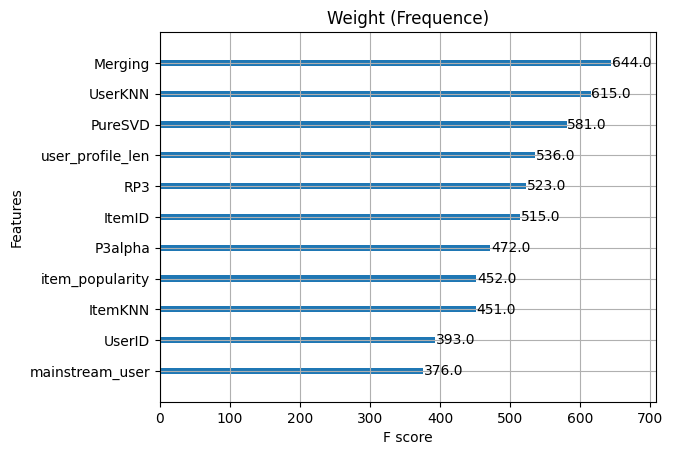

In [31]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [32]:
pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=10)
user_factors_validation = pure_svd.USER_factors

recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_train_complete, [recommender_item, recommender_rp3, recommender_p3a], weights)

PureSVDRecommender: URM Detected 851 ( 6.5%) users with no interactions.
PureSVDRecommender: URM Detected 476 ( 2.1%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.22 sec
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4643.27 column/sec. Elapsed time 4.81 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4694.57 column/sec. Elapsed time 2.77 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2691.77 column/sec. Elapsed time 8.30 sec
P3alphaRecommender: URM Detected 627 ( 4.

In [33]:
cutoff = 30
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
    # recommendations = recommender_item.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    validation_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_19/2423091730.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/2423091730.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN,item_popularity,user_profile_len
0,0,35,3.245894,0.532635,0.465694,0.185291,0.578219,0.667676,571,34
1,0,100,2.917171,0.369105,0.345509,0.103454,0.443021,0.588078,333,34
2,0,402,1.204698,0.222137,0.131656,0.032655,0.290169,0.423680,104,34
3,0,505,1.330598,0.222410,0.133074,0.033886,0.260055,0.333933,105,34
4,0,122,3.385918,0.202956,0.162935,-0.003590,0.231717,0.288159,155,34
...,...,...,...,...,...,...,...,...,...,...
390715,13023,328,1.906008,0.121553,0.061053,0.078644,0.204092,0.366070,154,60
390716,13023,9090,0.917949,0.142854,0.081498,0.013698,0.192099,0.288740,10,60
390717,13023,827,0.428111,0.110307,0.081467,0.009986,0.183476,0.327065,68,60
390718,13023,836,0.224060,0.100001,0.077348,0.002480,0.179153,0.334486,68,60


In [34]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

# mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
# validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

# user_factors_df = pd.DataFrame(user_factors_validation, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

# validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe

,UserID,ItemID,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN,item_popularity,user_profile_len,mainstream_user
0,0,35,3.245894,0.532635,0.465694,0.185291,0.578219,0.667676,571,34,130.705882
1,0,100,2.917171,0.369105,0.345509,0.103454,0.443021,0.588078,333,34,130.705882
2,0,402,1.204698,0.222137,0.131656,0.032655,0.290169,0.423680,104,34,130.705882
3,0,505,1.330598,0.222410,0.133074,0.033886,0.260055,0.333933,105,34,130.705882
4,0,122,3.385918,0.202956,0.162935,-0.003590,0.231717,0.288159,155,34,130.705882
...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,328,1.906008,0.121553,0.061053,0.078644,0.204092,0.366070,154,60,123.450000
390716,13023,9090,0.917949,0.142854,0.081498,0.013698,0.192099,0.288740,10,60,123.450000
390717,13023,827,0.428111,0.110307,0.081467,0.009986,0.183476,0.327065,68,60,123.450000
390718,13023,836,0.224060,0.100001,0.077348,0.002480,0.179153,0.334486,68,60,123.450000


In [35]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

In [36]:
class TmpRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [37]:
recommender = TmpRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 56.68 sec. Users per second: 184


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.095524,0.164273,0.138767,0.033352,0.049261,0.164404,0.113525,0.113155,0.520562,0.231197,...,0.802826,0.417921,0.802826,0.069072,10.432797,0.998113,0.199299,0.803702,1.677549,0.302951


In [38]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = 'rank:pairwise',
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        three_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = TmpRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [39]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [40]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_xgboost_better', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-11-30 23:49:33,854] A new study created in RDB with name: hyperparameters_tuning_xgboost_better
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.77 sec. Users per second: 184


[I 2023-11-30 23:50:35,473] Trial 0 finished with value: 0.031115471788052053 and parameters: {'n_estimators': 43, 'learning_rate': 0.04225165068761518, 'reg_alpha': 2.8871829005728433e-05, 'reg_lambda': 0.027289178997836616, 'max_depth': 13, 'max_leaves': 355, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 0.001312285144465285, 'min_child_weight': 1.1401453684341645e-06, 'subsample': 0.2577889217419392, 'colsample_bytree': 0.7084389250972783}. Best is trial 0 with value: 0.031115471788052053.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:50:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.52 min. Users per second: 115


[I 2023-11-30 23:53:10,017] Trial 1 finished with value: 0.03315821553053749 and parameters: {'n_estimators': 870, 'learning_rate': 0.0009001307448421486, 'reg_alpha': 0.026500152622152034, 'reg_lambda': 0.13609548071189062, 'max_depth': 9, 'max_leaves': 231, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 1.3775508095166589, 'min_child_weight': 0.00032322144408656104, 'subsample': 0.33831003104932966, 'colsample_bytree': 0.6098645905367811}. Best is trial 1 with value: 0.03315821553053749.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:53:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.80 sec. Users per second: 178


[I 2023-11-30 23:58:13,161] Trial 2 finished with value: 0.031341369275330676 and parameters: {'n_estimators': 3499, 'learning_rate': 0.03159276173811764, 'reg_alpha': 0.0002489570740181032, 'reg_lambda': 0.001085745098937539, 'max_depth': 4, 'max_leaves': 30, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.025766649486899672, 'min_child_weight': 0.012387193356687441, 'subsample': 0.4964953922315868, 'colsample_bytree': 0.6862239049213502}. Best is trial 1 with value: 0.03315821553053749.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:58:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.93 sec. Users per second: 177


[I 2023-11-30 23:59:14,784] Trial 3 finished with value: 0.02642537967112377 and parameters: {'n_estimators': 38, 'learning_rate': 0.014173222541703279, 'reg_alpha': 0.012057335305440063, 'reg_lambda': 0.382039943770299, 'max_depth': 4, 'max_leaves': 472, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.1279512192357368, 'min_child_weight': 1.1357568475717165e-07, 'subsample': 0.3747185082438662, 'colsample_bytree': 0.7371908910991176}. Best is trial 1 with value: 0.03315821553053749.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:59:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.08 sec. Users per second: 183


[I 2023-12-01 00:00:13,025] Trial 4 finished with value: 0.026400361757812057 and parameters: {'n_estimators': 14, 'learning_rate': 0.0857511726716319, 'reg_alpha': 0.006170227280281933, 'reg_lambda': 2.192754571853114e-05, 'max_depth': 11, 'max_leaves': 798, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.33821949707266e-07, 'min_child_weight': 1.6020306133673602e-07, 'subsample': 0.39501832680509064, 'colsample_bytree': 0.35352099864704356}. Best is trial 1 with value: 0.03315821553053749.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:00:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.41 sec. Users per second: 185


[I 2023-12-01 00:01:14,284] Trial 5 finished with value: 0.02649233446885514 and parameters: {'n_estimators': 64, 'learning_rate': 0.029966322839371704, 'reg_alpha': 4.6876946405750524e-05, 'reg_lambda': 0.40484211778446444, 'max_depth': 15, 'max_leaves': 854, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 1.8673936880590722, 'min_child_weight': 0.05948390598210354, 'subsample': 0.7770057300955434, 'colsample_bytree': 0.5962681249640515}. Best is trial 1 with value: 0.03315821553053749.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.25 min. Users per second: 139


[I 2023-12-01 00:03:49,341] Trial 6 finished with value: 0.033419218554547436 and parameters: {'n_estimators': 1382, 'learning_rate': 0.00045075895868430175, 'reg_alpha': 0.004186204876883014, 'reg_lambda': 0.0019658035296634025, 'max_depth': 5, 'max_leaves': 67, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.04804273593825478, 'min_child_weight': 0.03545067890132244, 'subsample': 0.3903326407653209, 'colsample_bytree': 0.2689398189027805}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:03:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 59.34 sec. Users per second: 176


[I 2023-12-01 00:05:13,442] Trial 7 finished with value: 0.027702887231148506 and parameters: {'n_estimators': 368, 'learning_rate': 0.0838926902075802, 'reg_alpha': 0.0022903287008956244, 'reg_lambda': 0.012993614691833142, 'max_depth': 12, 'max_leaves': 60, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 0.0001702407756055369, 'min_child_weight': 0.00012384114535049298, 'subsample': 0.2513865420349253, 'colsample_bytree': 0.6086494959367501}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:05:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.91 sec. Users per second: 181


[I 2023-12-01 00:10:44,542] Trial 8 finished with value: 0.03278180447772067 and parameters: {'n_estimators': 3387, 'learning_rate': 0.2348013924229771, 'reg_alpha': 0.00031087262861822867, 'reg_lambda': 0.0001243908219485667, 'max_depth': 5, 'max_leaves': 975, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 1.2877169456945174e-07, 'min_child_weight': 1.7374231563348805e-05, 'subsample': 0.4681483447746664, 'colsample_bytree': 0.41441015803583925}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:10:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 5.19 min. Users per second: 34


[I 2023-12-01 00:21:09,397] Trial 9 finished with value: 0.03046042524380314 and parameters: {'n_estimators': 3587, 'learning_rate': 0.003397881618409395, 'reg_alpha': 0.081943255933846, 'reg_lambda': 1.727082364951098e-05, 'max_depth': 16, 'max_leaves': 662, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 0.00032765432957364326, 'min_child_weight': 2.886969095150295e-07, 'subsample': 0.30343067386888956, 'colsample_bytree': 0.7525775726824773}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:21:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.71 sec. Users per second: 178


[I 2023-12-01 00:22:43,127] Trial 10 finished with value: 0.03208196706379556 and parameters: {'n_estimators': 691, 'learning_rate': 0.00010627124953848819, 'reg_alpha': 0.2101081516215052, 'reg_lambda': 0.0012915658915768548, 'max_depth': 20, 'max_leaves': 240, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 9.112856957745397, 'min_child_weight': 0.6742354972160761, 'subsample': 0.122369045334486, 'colsample_bytree': 0.14661626603011083}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:22:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.49 min. Users per second: 117


[I 2023-12-01 00:25:21,349] Trial 11 finished with value: 0.032880373234475985 and parameters: {'n_estimators': 965, 'learning_rate': 0.0010271859547635281, 'reg_alpha': 0.051310900338873, 'reg_lambda': 0.007567478124491935, 'max_depth': 8, 'max_leaves': 224, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.23274936689640505, 'min_child_weight': 0.0026883788729781207, 'subsample': 0.6065028783297162, 'colsample_bytree': 0.48427057151788544}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:25:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.27 min. Users per second: 138


[I 2023-12-01 00:27:48,333] Trial 12 finished with value: 0.03328825023378382 and parameters: {'n_estimators': 1178, 'learning_rate': 0.0005721092810263652, 'reg_alpha': 0.027995527447352772, 'reg_lambda': 0.03536985233692309, 'max_depth': 7, 'max_leaves': 189, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 8.63675606163148, 'min_child_weight': 0.0007956962692607306, 'subsample': 0.622787846896049, 'colsample_bytree': 0.2747909935707238}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:27:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.02 min. Users per second: 170


[I 2023-12-01 00:29:05,128] Trial 13 finished with value: 0.03248067487642837 and parameters: {'n_estimators': 246, 'learning_rate': 0.00011421849925695701, 'reg_alpha': 0.9625401308010502, 'reg_lambda': 0.03774792406850451, 'max_depth': 7, 'max_leaves': 124, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 5.771736739545799, 'min_child_weight': 0.0033932286973608495, 'subsample': 0.6026030009829256, 'colsample_bytree': 0.2593377421214439}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:29:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.51 min. Users per second: 115


[I 2023-12-01 00:32:17,617] Trial 14 finished with value: 0.0333100687992614 and parameters: {'n_estimators': 1675, 'learning_rate': 0.00036603129959476854, 'reg_alpha': 0.00182399453107884, 'reg_lambda': 0.004825380994787761, 'max_depth': 6, 'max_leaves': 421, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.013263693840124663, 'min_child_weight': 0.10049330226358504, 'subsample': 0.8935082915713108, 'colsample_bytree': 0.25268216416936073}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:32:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.18 min. Users per second: 147


[I 2023-12-01 00:35:32,299] Trial 15 finished with value: 0.032607741738623415 and parameters: {'n_estimators': 2434, 'learning_rate': 0.0003785742512734702, 'reg_alpha': 0.0018688848340310772, 'reg_lambda': 0.0023412588200757006, 'max_depth': 3, 'max_leaves': 524, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.013447241206242341, 'min_child_weight': 0.8483091311829903, 'subsample': 0.7969336500693598, 'colsample_bytree': 0.11650539915002944}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:35:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 2.17 min. Users per second: 80


[I 2023-12-01 00:40:03,841] Trial 16 finished with value: 0.030060931826186167 and parameters: {'n_estimators': 1750, 'learning_rate': 0.003475388885427427, 'reg_alpha': 0.0008700167760998978, 'reg_lambda': 0.000471205602682683, 'max_depth': 10, 'max_leaves': 395, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.004316995863566481, 'min_child_weight': 0.0746852622213357, 'subsample': 0.8770244477666287, 'colsample_bytree': 0.879236328956552}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 2.57 min. Users per second: 68


[I 2023-12-01 00:47:30,359] Trial 17 finished with value: 0.03337410129825953 and parameters: {'n_estimators': 4847, 'learning_rate': 0.0002986154893285486, 'reg_alpha': 0.006240669451020639, 'reg_lambda': 0.004952313954141377, 'max_depth': 6, 'max_leaves': 633, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.09001637600953773, 'min_child_weight': 0.08787562224917995, 'subsample': 0.8972397297360442, 'colsample_bytree': 0.20500170628084333}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:47:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.32 min. Users per second: 132


[I 2023-12-01 00:52:29,544] Trial 18 finished with value: 0.033170732077579694 and parameters: {'n_estimators': 4454, 'learning_rate': 0.0025618327452448476, 'reg_alpha': 0.008139115937507659, 'reg_lambda': 0.00038316732349663135, 'max_depth': 3, 'max_leaves': 599, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.17126220650866872, 'min_child_weight': 0.014639762975647756, 'subsample': 0.6928454258950858, 'colsample_bytree': 0.16863056151171674}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:52:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.06 min. Users per second: 164


[I 2023-12-01 00:54:03,206] Trial 19 finished with value: 0.033144966511215374 and parameters: {'n_estimators': 473, 'learning_rate': 0.00022061513369040989, 'reg_alpha': 0.005912014220356824, 'reg_lambda': 0.004997138637938585, 'max_depth': 6, 'max_leaves': 706, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.06554252723467162, 'min_child_weight': 0.20473605759185692, 'subsample': 0.4545553223933347, 'colsample_bytree': 0.3563040196078704}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:54:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.97 min. Users per second: 89


[I 2023-12-01 00:58:04,702] Trial 20 finished with value: 0.032190790432469654 and parameters: {'n_estimators': 1793, 'learning_rate': 0.001476311525544545, 'reg_alpha': 0.016340703965401715, 'reg_lambda': 0.003323704347839731, 'max_depth': 9, 'max_leaves': 325, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.8141876382464632, 'min_child_weight': 0.01799459285495173, 'subsample': 0.5490236339505765, 'colsample_bytree': 0.20148492698840437}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:58:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.39 min. Users per second: 126


[I 2023-12-01 01:01:17,337] Trial 21 finished with value: 0.03279985441639027 and parameters: {'n_estimators': 1901, 'learning_rate': 0.00029123118981164647, 'reg_alpha': 0.00271702912893279, 'reg_lambda': 0.0068745501903036835, 'max_depth': 6, 'max_leaves': 539, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.011628252142413798, 'min_child_weight': 0.09286469180627929, 'subsample': 0.894647079279025, 'colsample_bytree': 0.10241478705609501}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.18 min. Users per second: 148


[I 2023-12-01 01:03:48,202] Trial 22 finished with value: 0.03324769859486753 and parameters: {'n_estimators': 1420, 'learning_rate': 0.0005907627035040958, 'reg_alpha': 0.0011321323162121716, 'reg_lambda': 0.00204974370898728, 'max_depth': 5, 'max_leaves': 445, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.041706633249937924, 'min_child_weight': 0.2981299877641672, 'subsample': 0.8067451759403876, 'colsample_bytree': 0.23905942314339068}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:03:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 3.31 min. Users per second: 53


[I 2023-12-01 01:12:04,347] Trial 23 finished with value: 0.03283016282896717 and parameters: {'n_estimators': 4293, 'learning_rate': 0.00020636428833034647, 'reg_alpha': 0.004305402635470083, 'reg_lambda': 0.011694698543108877, 'max_depth': 8, 'max_leaves': 763, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.006263698969830561, 'min_child_weight': 0.046255439527159645, 'subsample': 0.7204643255377773, 'colsample_bytree': 0.2982595367727406}. Best is trial 6 with value: 0.033419218554547436.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:12:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.63 min. Users per second: 107


[I 2023-12-01 01:16:02,113] Trial 24 finished with value: 0.033583102585589115 and parameters: {'n_estimators': 2357, 'learning_rate': 0.0005173137634681166, 'reg_alpha': 0.00046654941162918074, 'reg_lambda': 0.0006058729221653929, 'max_depth': 6, 'max_leaves': 633, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.48737537765100447, 'min_child_weight': 0.2648969353897298, 'subsample': 0.8941864164584935, 'colsample_bytree': 0.2026634833363096}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:16:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.13 min. Users per second: 155


[I 2023-12-01 01:19:26,996] Trial 25 finished with value: 0.03330189395319447 and parameters: {'n_estimators': 2706, 'learning_rate': 0.0017039626435565514, 'reg_alpha': 0.0005891226150387631, 'reg_lambda': 0.0006930281102612196, 'max_depth': 3, 'max_leaves': 612, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.4834313070635639, 'min_child_weight': 0.27442078696667827, 'subsample': 0.8459533570416163, 'colsample_bytree': 0.21712773841576127}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:19:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.88 min. Users per second: 93


[I 2023-12-01 01:25:43,656] Trial 26 finished with value: 0.032848402527294894 and parameters: {'n_estimators': 4890, 'learning_rate': 0.0007128230877851291, 'reg_alpha': 8.903642541153206e-05, 'reg_lambda': 0.00013590546984491243, 'max_depth': 5, 'max_leaves': 897, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 0.18479246981929648, 'min_child_weight': 0.7035561433510664, 'subsample': 0.7313889341047285, 'colsample_bytree': 0.16426933817252345}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:25:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.63 min. Users per second: 107


[I 2023-12-01 01:29:45,114] Trial 27 finished with value: 0.033444361709233546 and parameters: {'n_estimators': 2554, 'learning_rate': 0.00556760140774394, 'reg_alpha': 0.000409247340959967, 'reg_lambda': 0.0018358265150222842, 'max_depth': 8, 'max_leaves': 697, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.6134816802055005, 'min_child_weight': 0.022881974878211912, 'subsample': 0.8422943751882911, 'colsample_bytree': 0.18016151464357014}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:29:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.42 min. Users per second: 123


[I 2023-12-01 01:32:04,029] Trial 28 finished with value: 0.030333362176801243 and parameters: {'n_estimators': 729, 'learning_rate': 0.007555147915565075, 'reg_alpha': 1.4454485771629977e-05, 'reg_lambda': 0.0014024784422015492, 'max_depth': 10, 'max_leaves': 744, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.770117345362237, 'min_child_weight': 0.005822298362831168, 'subsample': 0.8134657789265386, 'colsample_bytree': 0.3159757081892424}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:32:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.53 min. Users per second: 114


[I 2023-12-01 01:35:41,160] Trial 29 finished with value: 0.03348293605251325 and parameters: {'n_estimators': 2300, 'learning_rate': 0.0051943014102518665, 'reg_alpha': 0.0002820214008017571, 'reg_lambda': 0.000270716841364074, 'max_depth': 14, 'max_leaves': 325, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 1.573191389513083, 'min_child_weight': 0.021604432390458794, 'subsample': 0.6739403765195535, 'colsample_bytree': 0.10182308860927725}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:35:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.31 min. Users per second: 134


[I 2023-12-01 01:38:55,046] Trial 30 finished with value: 0.033537135206033304 and parameters: {'n_estimators': 2273, 'learning_rate': 0.006641515083332379, 'reg_alpha': 0.00014622971231708262, 'reg_lambda': 0.000200387709617594, 'max_depth': 15, 'max_leaves': 315, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 2.324474294790418, 'min_child_weight': 0.018601782380302547, 'subsample': 0.8415178098836995, 'colsample_bytree': 0.1149634114266665}. Best is trial 24 with value: 0.033583102585589115.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:38:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.33 min. Users per second: 131


[I 2023-12-01 01:42:15,045] Trial 31 finished with value: 0.03362646646263695 and parameters: {'n_estimators': 2326, 'learning_rate': 0.0047317186686458915, 'reg_alpha': 0.0001373141322361214, 'reg_lambda': 0.0002689122811843782, 'max_depth': 15, 'max_leaves': 336, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 2.2596836240361835, 'min_child_weight': 0.0224348297469932, 'subsample': 0.8353630488530472, 'colsample_bytree': 0.1082579402100845}. Best is trial 31 with value: 0.03362646646263695.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:42:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.07 min. Users per second: 163


[I 2023-12-01 01:44:12,564] Trial 32 finished with value: 0.03366935214534664 and parameters: {'n_estimators': 1029, 'learning_rate': 0.008911452649383445, 'reg_alpha': 0.0001293140713080019, 'reg_lambda': 0.0002049732377026045, 'max_depth': 15, 'max_leaves': 329, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 2.9129398237990864, 'min_child_weight': 0.006079848796360472, 'subsample': 0.7534672870694434, 'colsample_bytree': 0.11213417818310252}. Best is trial 32 with value: 0.03366935214534664.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:44:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.10 min. Users per second: 158


[I 2023-12-01 01:46:10,315] Trial 33 finished with value: 0.03374230714346416 and parameters: {'n_estimators': 997, 'learning_rate': 0.0098690032032352, 'reg_alpha': 0.00014679425288384915, 'reg_lambda': 0.0001745409339518198, 'max_depth': 17, 'max_leaves': 286, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 2.5177480297429446, 'min_child_weight': 0.0071534645554103965, 'subsample': 0.7627629507748093, 'colsample_bytree': 0.14704561758242768}. Best is trial 33 with value: 0.03374230714346416.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:46:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.07 min. Users per second: 162


[I 2023-12-01 01:48:07,246] Trial 34 finished with value: 0.033738895264813204 and parameters: {'n_estimators': 997, 'learning_rate': 0.011873696566978774, 'reg_alpha': 0.0001256212417087758, 'reg_lambda': 7.554568857042087e-05, 'max_depth': 18, 'max_leaves': 257, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 2.8103194949249435, 'min_child_weight': 0.005791570235043532, 'subsample': 0.7671715949430037, 'colsample_bytree': 0.15118034598407967}. Best is trial 33 with value: 0.03374230714346416.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:48:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.99 sec. Users per second: 180


[I 2023-12-01 01:50:07,392] Trial 35 finished with value: 0.0336697544358217 and parameters: {'n_estimators': 985, 'learning_rate': 0.012906446451690983, 'reg_alpha': 6.862342163421455e-05, 'reg_lambda': 5.478043405221868e-05, 'max_depth': 19, 'max_leaves': 157, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 3.31583093357408, 'min_child_weight': 0.0013099992488226075, 'subsample': 0.7814515545185974, 'colsample_bytree': 0.1749198694982038}. Best is trial 33 with value: 0.03374230714346416.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:50:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.79 sec. Users per second: 187


[I 2023-12-01 01:52:04,983] Trial 36 finished with value: 0.033651651364447775 and parameters: {'n_estimators': 953, 'learning_rate': 0.01279715744203446, 'reg_alpha': 3.105067361341821e-05, 'reg_lambda': 5.3702453102941636e-05, 'max_depth': 18, 'max_leaves': 140, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 3.9379215619836767, 'min_child_weight': 0.0012438264123506048, 'subsample': 0.7490391239106278, 'colsample_bytree': 0.15047140316069377}. Best is trial 33 with value: 0.03374230714346416.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:52:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.04 sec. Users per second: 190


[I 2023-12-01 01:53:35,529] Trial 37 finished with value: 0.03339384389307872 and parameters: {'n_estimators': 567, 'learning_rate': 0.01735569961065771, 'reg_alpha': 4.555444666407138e-05, 'reg_lambda': 4.9051623725653965e-05, 'max_depth': 18, 'max_leaves': 262, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 3.4136809935265484, 'min_child_weight': 0.008697101088621586, 'subsample': 0.7686723858778188, 'colsample_bytree': 0.1610517817631914}. Best is trial 33 with value: 0.03374230714346416.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:53:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.38 sec. Users per second: 185


[I 2023-12-01 01:55:37,088] Trial 38 finished with value: 0.033904354301016425 and parameters: {'n_estimators': 1020, 'learning_rate': 0.023778904603228374, 'reg_alpha': 1.3596246688060194e-05, 'reg_lambda': 3.8626128277461426e-05, 'max_depth': 18, 'max_leaves': 152, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 9.879734173763612, 'min_child_weight': 0.004903904015126869, 'subsample': 0.7682805670559892, 'colsample_bytree': 0.22547215754761313}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:55:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.80 sec. Users per second: 187


[I 2023-12-01 01:57:06,773] Trial 39 finished with value: 0.03364460748594256 and parameters: {'n_estimators': 527, 'learning_rate': 0.02494084506459482, 'reg_alpha': 1.0765403514300901e-05, 'reg_lambda': 1.0616012076560653e-05, 'max_depth': 20, 'max_leaves': 144, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 8.214952877716424, 'min_child_weight': 0.0002823207430826724, 'subsample': 0.6699431483476408, 'colsample_bytree': 0.22284686307194057}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:57:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.74 sec. Users per second: 188


[I 2023-12-01 01:58:19,093] Trial 40 finished with value: 0.033810081702918215 and parameters: {'n_estimators': 294, 'learning_rate': 0.048902225004869564, 'reg_alpha': 2.0390404685428586e-05, 'reg_lambda': 5.082714892873275e-05, 'max_depth': 18, 'max_leaves': 22, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.3632771235428216, 'min_child_weight': 0.001978665021350645, 'subsample': 0.7127325625122831, 'colsample_bytree': 0.32649220658901806}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:58:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.18 sec. Users per second: 186


[I 2023-12-01 01:59:38,588] Trial 41 finished with value: 0.03384053812802845 and parameters: {'n_estimators': 364, 'learning_rate': 0.03915474874018222, 'reg_alpha': 2.6492005497855416e-05, 'reg_lambda': 5.5910864094025064e-05, 'max_depth': 17, 'max_leaves': 21, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 9.71416079793443, 'min_child_weight': 0.0020393104146977084, 'subsample': 0.7865978017870529, 'colsample_bytree': 0.23142009836903193}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:59:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.37 sec. Users per second: 185


[I 2023-12-01 02:00:55,768] Trial 42 finished with value: 0.033726120644636225 and parameters: {'n_estimators': 329, 'learning_rate': 0.04824825770913174, 'reg_alpha': 1.798830352311196e-05, 'reg_lambda': 2.827473332538593e-05, 'max_depth': 17, 'max_leaves': 18, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.4420263048194322, 'min_child_weight': 0.0029390055959477353, 'subsample': 0.7175802093966982, 'colsample_bytree': 0.3306655916693186}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:00:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.35 sec. Users per second: 186


[I 2023-12-01 02:02:01,100] Trial 43 finished with value: 0.03340039819166629 and parameters: {'n_estimators': 157, 'learning_rate': 0.04692552026399692, 'reg_alpha': 2.4304384327930513e-05, 'reg_lambda': 8.489231326331184e-05, 'max_depth': 17, 'max_leaves': 78, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 8.26638963892572, 'min_child_weight': 0.0007121924766198861, 'subsample': 0.7774904499336396, 'colsample_bytree': 0.2768421852770976}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:02:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 54.92 sec. Users per second: 190


[I 2023-12-01 02:03:39,372] Trial 44 finished with value: 0.03383446202377908 and parameters: {'n_estimators': 677, 'learning_rate': 0.025526520750387485, 'reg_alpha': 1.0474752923651818e-05, 'reg_lambda': 2.973777881260952e-05, 'max_depth': 19, 'max_leaves': 84, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.30779375253359303, 'min_child_weight': 0.007145330907718787, 'subsample': 0.6903383690118124, 'colsample_bytree': 0.23488805513897754}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:03:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.71 sec. Users per second: 184


[I 2023-12-01 02:04:59,242] Trial 45 finished with value: 0.03364054662926117 and parameters: {'n_estimators': 402, 'learning_rate': 0.026939420327428503, 'reg_alpha': 2.796135800433117e-05, 'reg_lambda': 3.102697564437046e-05, 'max_depth': 19, 'max_leaves': 84, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.33717378368474976, 'min_child_weight': 0.0025290611212909733, 'subsample': 0.6948855228640015, 'colsample_bytree': 0.377485169307003}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:04:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.92 sec. Users per second: 184


[I 2023-12-01 02:06:36,994] Trial 46 finished with value: 0.03375474019625689 and parameters: {'n_estimators': 728, 'learning_rate': 0.06614017193716762, 'reg_alpha': 1.0831317350911178e-05, 'reg_lambda': 1.4505480496301919e-05, 'max_depth': 13, 'max_leaves': 14, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.211489523186331, 'min_child_weight': 0.00953136897938704, 'subsample': 0.6394813300527536, 'colsample_bytree': 0.24332080418525}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:06:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 59.45 sec. Users per second: 176


[I 2023-12-01 02:08:18,074] Trial 47 finished with value: 0.033789458623285966 and parameters: {'n_estimators': 636, 'learning_rate': 0.07726300875879305, 'reg_alpha': 1.0138482858134697e-05, 'reg_lambda': 1.501910582270832e-05, 'max_depth': 13, 'max_leaves': 10, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.1946233189924138, 'min_child_weight': 0.0002642957518693499, 'subsample': 0.6406407020689899, 'colsample_bytree': 0.3127931403216214}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:08:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.02 sec. Users per second: 180


[I 2023-12-01 02:09:34,138] Trial 48 finished with value: 0.03387754505653305 and parameters: {'n_estimators': 268, 'learning_rate': 0.19251211320266404, 'reg_alpha': 1.5838734630198856e-05, 'reg_lambda': 2.1539796209197818e-05, 'max_depth': 16, 'max_leaves': 194, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 9.406516190916323, 'min_child_weight': 0.00017803682441599894, 'subsample': 0.5767578789390818, 'colsample_bytree': 0.39168188363807666}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:09:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 59.70 sec. Users per second: 175


[I 2023-12-01 02:10:48,668] Trial 49 finished with value: 0.03368920480076741 and parameters: {'n_estimators': 211, 'learning_rate': 0.11622808087534824, 'reg_alpha': 4.4886483719247136e-05, 'reg_lambda': 2.7395897990837107e-05, 'max_depth': 16, 'max_leaves': 203, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 8.976649380054832, 'min_child_weight': 6.21587975499637e-05, 'subsample': 0.6060213561084585, 'colsample_bytree': 0.4009202373652673}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:10:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.64 sec. Users per second: 181


[I 2023-12-01 02:12:04,087] Trial 50 finished with value: 0.03389426288240354 and parameters: {'n_estimators': 292, 'learning_rate': 0.12738557594030686, 'reg_alpha': 1.717749188599114e-05, 'reg_lambda': 2.0516582205078044e-05, 'max_depth': 19, 'max_leaves': 102, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.3696960571268043, 'min_child_weight': 0.00045235966240287495, 'subsample': 0.5697775796894256, 'colsample_bytree': 0.43761293981173366}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:12:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.58 sec. Users per second: 182


[I 2023-12-01 02:13:21,763] Trial 51 finished with value: 0.03381661323034683 and parameters: {'n_estimators': 298, 'learning_rate': 0.1461641921231003, 'reg_alpha': 1.8938021863114737e-05, 'reg_lambda': 2.147168435830745e-05, 'max_depth': 19, 'max_leaves': 100, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.3040668035033799, 'min_child_weight': 0.0007456162845556942, 'subsample': 0.5596962026849243, 'colsample_bytree': 0.43351159386159227}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:13:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.62 sec. Users per second: 185


[I 2023-12-01 02:14:43,033] Trial 52 finished with value: 0.03377141247980937 and parameters: {'n_estimators': 388, 'learning_rate': 0.15236762292110229, 'reg_alpha': 1.669196531775633e-05, 'reg_lambda': 1.0235300250363547e-05, 'max_depth': 20, 'max_leaves': 100, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.22416863327139805, 'min_child_weight': 0.0004914233833091219, 'subsample': 0.5570049790399121, 'colsample_bytree': 0.4504712697038958}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:14:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.01 sec. Users per second: 183


[I 2023-12-01 02:15:51,553] Trial 53 finished with value: 0.03380837766118932 and parameters: {'n_estimators': 206, 'learning_rate': 0.43471055959919447, 'reg_alpha': 3.55637053831698e-05, 'reg_lambda': 2.140333677167447e-05, 'max_depth': 19, 'max_leaves': 180, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.07864874531019103, 'min_child_weight': 0.0001416672182908371, 'subsample': 0.5790008714496337, 'colsample_bytree': 0.4308959688086533}. Best is trial 38 with value: 0.033904354301016425.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:15:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.87 sec. Users per second: 187


[I 2023-12-01 02:16:56,912] Trial 54 finished with value: 0.033954894888330145 and parameters: {'n_estimators': 149, 'learning_rate': 0.17542204744974896, 'reg_alpha': 2.6016339837876325e-05, 'reg_lambda': 2.904328139436011e-05, 'max_depth': 16, 'max_leaves': 55, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 4.817490843214988, 'min_child_weight': 0.0010177064880912143, 'subsample': 0.5267424786138228, 'colsample_bytree': 0.5268127533786527}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:16:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.99 sec. Users per second: 187


[I 2023-12-01 02:18:03,081] Trial 55 finished with value: 0.03370004387243283 and parameters: {'n_estimators': 149, 'learning_rate': 0.2342893675150681, 'reg_alpha': 5.9122505120305115e-05, 'reg_lambda': 3.750210955206494e-05, 'max_depth': 16, 'max_leaves': 54, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 5.0715690559235025, 'min_child_weight': 0.0016616155837867654, 'subsample': 0.5154521463655275, 'colsample_bytree': 0.5590123570737399}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:18:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.76 sec. Users per second: 181


[I 2023-12-01 02:19:32,983] Trial 56 finished with value: 0.033244620693214745 and parameters: {'n_estimators': 495, 'learning_rate': 0.019852590347206954, 'reg_alpha': 2.9402304417764773e-05, 'reg_lambda': 8.004337520868092e-05, 'max_depth': 17, 'max_leaves': 217, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 5.704239963837205, 'min_child_weight': 0.0035281203259368344, 'subsample': 0.5094038665925466, 'colsample_bytree': 0.5033141114952121}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:19:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.37 sec. Users per second: 179


[I 2023-12-01 02:20:38,194] Trial 57 finished with value: 0.033108126571209984 and parameters: {'n_estimators': 103, 'learning_rate': 0.03409592311608691, 'reg_alpha': 1.483314163138176e-05, 'reg_lambda': 1.711884022816085e-05, 'max_depth': 14, 'max_leaves': 119, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 9.753454101886057, 'min_child_weight': 0.000488684056257825, 'subsample': 0.4570525768518122, 'colsample_bytree': 0.36028156221513086}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:20:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.96 sec. Users per second: 184


[I 2023-12-01 02:22:02,751] Trial 58 finished with value: 0.03370257906146382 and parameters: {'n_estimators': 435, 'learning_rate': 0.06334125261154874, 'reg_alpha': 4.5865428900401904e-05, 'reg_lambda': 3.4660858383408946e-05, 'max_depth': 16, 'max_leaves': 53, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9247718565099334, 'min_child_weight': 0.0012680133014226509, 'subsample': 0.6548940984211353, 'colsample_bytree': 0.3874674696397393}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:22:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.74 sec. Users per second: 184


[I 2023-12-01 02:23:14,563] Trial 59 finished with value: 0.03353033421989044 and parameters: {'n_estimators': 272, 'learning_rate': 0.10653693879694154, 'reg_alpha': 2.4991788903061436e-05, 'reg_lambda': 0.00010154113651792538, 'max_depth': 18, 'max_leaves': 384, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 4.224601830264415, 'min_child_weight': 2.480439671357955e-05, 'subsample': 0.617837576769171, 'colsample_bytree': 0.2848622739368748}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:23:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.21 sec. Users per second: 186


[I 2023-12-01 02:25:01,185] Trial 60 finished with value: 0.033645829538140055 and parameters: {'n_estimators': 762, 'learning_rate': 0.039081806072576275, 'reg_alpha': 6.88552083943428e-05, 'reg_lambda': 2.3179014489028104e-05, 'max_depth': 20, 'max_leaves': 167, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.6522263706629443, 'min_child_weight': 0.003831586820930335, 'subsample': 0.5839836192926248, 'colsample_bytree': 0.26613713106600867}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:25:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.78 sec. Users per second: 184


[I 2023-12-01 02:26:18,209] Trial 61 finished with value: 0.033843012593968824 and parameters: {'n_estimators': 311, 'learning_rate': 0.16995971700849774, 'reg_alpha': 1.7134302616547217e-05, 'reg_lambda': 1.7702879586249977e-05, 'max_depth': 19, 'max_leaves': 109, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.13175429008686895, 'min_child_weight': 0.0007730356175276202, 'subsample': 0.539372952819422, 'colsample_bytree': 0.4560181492835153}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:26:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.38 sec. Users per second: 189


[I 2023-12-01 02:27:37,111] Trial 62 finished with value: 0.0337664787287012 and parameters: {'n_estimators': 354, 'learning_rate': 0.20770756616044164, 'reg_alpha': 1.3213141407036102e-05, 'reg_lambda': 1.3375162870312978e-05, 'max_depth': 19, 'max_leaves': 56, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.10676005222713338, 'min_child_weight': 0.00017267305566344044, 'subsample': 0.5241833307084258, 'colsample_bytree': 0.4731597376042832}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:27:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.78 sec. Users per second: 184


[I 2023-12-01 02:28:50,759] Trial 63 finished with value: 0.033767514816434 and parameters: {'n_estimators': 252, 'learning_rate': 0.09549365454349083, 'reg_alpha': 2.0691103489445792e-05, 'reg_lambda': 3.772567902108334e-05, 'max_depth': 17, 'max_leaves': 112, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.3883028736076065, 'min_child_weight': 0.0005106457283953268, 'subsample': 0.4285410151269949, 'colsample_bytree': 0.37484434239237624}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:28:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.60 sec. Users per second: 188


[I 2023-12-01 02:30:17,566] Trial 64 finished with value: 0.03368046067572639 and parameters: {'n_estimators': 466, 'learning_rate': 0.3489642998441416, 'reg_alpha': 3.5939661738576556e-05, 'reg_lambda': 1.8295313191600516e-05, 'max_depth': 20, 'max_leaves': 188, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.1433644229214574, 'min_child_weight': 0.0011340180978469507, 'subsample': 0.538440877210977, 'colsample_bytree': 0.4060686470021077}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:30:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.78 sec. Users per second: 181


[I 2023-12-01 02:31:38,070] Trial 65 finished with value: 0.03368365243317421 and parameters: {'n_estimators': 340, 'learning_rate': 0.18745994890573242, 'reg_alpha': 1.0444889311226204e-05, 'reg_lambda': 0.0001236460511145828, 'max_depth': 18, 'max_leaves': 46, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.03833258422774014, 'min_child_weight': 0.0022935870383325014, 'subsample': 0.4947987099663773, 'colsample_bytree': 0.500536891449238}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:31:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.62 sec. Users per second: 181


[I 2023-12-01 02:33:13,904] Trial 66 finished with value: 0.033565276563315934 and parameters: {'n_estimators': 582, 'learning_rate': 0.3047364287163233, 'reg_alpha': 1.8627916683123248e-05, 'reg_lambda': 6.17532513631708e-05, 'max_depth': 16, 'max_leaves': 134, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 5.047791602590974, 'min_child_weight': 8.774573680271108e-05, 'subsample': 0.4894868029335908, 'colsample_bytree': 0.5400213097248291}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:33:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.30 sec. Users per second: 182


[I 2023-12-01 02:34:26,124] Trial 67 finished with value: 0.033575455271371395 and parameters: {'n_estimators': 232, 'learning_rate': 0.13360102867414078, 'reg_alpha': 1.4695850071627895e-05, 'reg_lambda': 1.0149901598991177e-05, 'max_depth': 19, 'max_leaves': 75, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.7757810330705677, 'min_child_weight': 0.0003440588459382934, 'subsample': 0.5824881706761594, 'colsample_bytree': 0.35482923706435465}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:34:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.37 sec. Users per second: 185


[I 2023-12-01 02:35:34,341] Trial 68 finished with value: 0.03363927903474567 and parameters: {'n_estimators': 174, 'learning_rate': 0.07596843498986205, 'reg_alpha': 3.32932332605891e-05, 'reg_lambda': 3.867444171042823e-05, 'max_depth': 14, 'max_leaves': 231, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.6882808212243688, 'min_child_weight': 0.0008990278911310785, 'subsample': 0.5384386566928526, 'colsample_bytree': 0.23751695060502998}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:35:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 60.00 sec. Users per second: 174


[I 2023-12-01 02:36:57,846] Trial 69 finished with value: 0.03377442586317861 and parameters: {'n_estimators': 351, 'learning_rate': 0.19239833636147263, 'reg_alpha': 2.3807688491452395e-05, 'reg_lambda': 2.639849975989824e-05, 'max_depth': 17, 'max_leaves': 110, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.2640057410914673, 'min_child_weight': 0.010383106441583495, 'subsample': 0.6337609337558695, 'colsample_bytree': 0.2930882398422309}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:36:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.07 min. Users per second: 163


[I 2023-12-01 02:39:34,333] Trial 70 finished with value: 0.033381999095225955 and parameters: {'n_estimators': 1246, 'learning_rate': 0.2801827361963755, 'reg_alpha': 9.398283362191596e-05, 'reg_lambda': 7.57386303196107e-05, 'max_depth': 16, 'max_leaves': 488, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 2.3958095687684047, 'min_child_weight': 0.0018867393769446555, 'subsample': 0.6822630868293199, 'colsample_bytree': 0.464756944366898}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:39:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.07 min. Users per second: 163


[I 2023-12-01 02:40:55,933] Trial 71 finished with value: 0.0338348453382882 and parameters: {'n_estimators': 302, 'learning_rate': 0.15321399498839822, 'reg_alpha': 1.531070130934203e-05, 'reg_lambda': 2.062418435403012e-05, 'max_depth': 19, 'max_leaves': 95, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.2681208522451114, 'min_child_weight': 0.0007345870200535698, 'subsample': 0.558141035178703, 'colsample_bytree': 0.43746404623253116}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:40:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.05 min. Users per second: 166


[I 2023-12-01 02:42:18,566] Trial 72 finished with value: 0.033837824564918906 and parameters: {'n_estimators': 281, 'learning_rate': 0.1673753644188092, 'reg_alpha': 1.4757151020358583e-05, 'reg_lambda': 1.7596123455085133e-05, 'max_depth': 19, 'max_leaves': 158, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.1677855555877639, 'min_child_weight': 0.0007849099407582141, 'subsample': 0.6017694621495049, 'colsample_bytree': 0.4345524417984891}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.06 min. Users per second: 164


[I 2023-12-01 02:43:40,867] Trial 73 finished with value: 0.03387609908793904 and parameters: {'n_estimators': 269, 'learning_rate': 0.16459147385487624, 'reg_alpha': 1.527651797067908e-05, 'reg_lambda': 1.817284955379101e-05, 'max_depth': 18, 'max_leaves': 169, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.13250564403444182, 'min_child_weight': 0.0007857554525910876, 'subsample': 0.6010819207416784, 'colsample_bytree': 0.4577630690224173}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:43:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.04 min. Users per second: 167


[I 2023-12-01 02:44:56,119] Trial 74 finished with value: 0.03362547591722219 and parameters: {'n_estimators': 187, 'learning_rate': 0.10538736108089611, 'reg_alpha': 3.6073663911572276e-05, 'reg_lambda': 1.4792658992510192e-05, 'max_depth': 18, 'max_leaves': 277, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.06324738740315951, 'min_child_weight': 0.00034107696119240664, 'subsample': 0.5995305250140729, 'colsample_bytree': 0.4173159428819777}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:44:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.01 min. Users per second: 173


[I 2023-12-01 02:46:13,726] Trial 75 finished with value: 0.03360667453030683 and parameters: {'n_estimators': 234, 'learning_rate': 0.48006687596301634, 'reg_alpha': 5.837359931404071e-05, 'reg_lambda': 4.8371018935357976e-05, 'max_depth': 20, 'max_leaves': 167, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.14619285323249726, 'min_child_weight': 0.004363370269569247, 'subsample': 0.4773249080383516, 'colsample_bytree': 0.4599313961504101}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:46:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.02 min. Users per second: 170


[I 2023-12-01 02:47:24,051] Trial 76 finished with value: 0.03385509648899075 and parameters: {'n_estimators': 115, 'learning_rate': 0.2553874228110118, 'reg_alpha': 2.3039344021519535e-05, 'reg_lambda': 1.277489367053964e-05, 'max_depth': 18, 'max_leaves': 196, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.025598270102494575, 'min_child_weight': 0.0016311782458392288, 'subsample': 0.5184673733410019, 'colsample_bytree': 0.4870241118407713}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:47:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 58.36 sec. Users per second: 179


[I 2023-12-01 02:48:30,405] Trial 77 finished with value: 0.033730894997631655 and parameters: {'n_estimators': 120, 'learning_rate': 0.2390203955486862, 'reg_alpha': 2.3099797355169548e-05, 'reg_lambda': 1.3782293977711296e-05, 'max_depth': 12, 'max_leaves': 232, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.017257167974933266, 'min_child_weight': 0.0015381513086183017, 'subsample': 0.5222197162422904, 'colsample_bytree': 0.4844827049912845}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:48:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.87 sec. Users per second: 181


[I 2023-12-01 02:49:34,263] Trial 78 finished with value: 0.033467838774122155 and parameters: {'n_estimators': 87, 'learning_rate': 0.12470637437997754, 'reg_alpha': 4.320076846617473e-05, 'reg_lambda': 4.021034724893255e-05, 'max_depth': 17, 'max_leaves': 197, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 5.0502970458816385, 'min_child_weight': 0.00020920259365110407, 'subsample': 0.49903406056192157, 'colsample_bytree': 0.532138525408919}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 57.27 sec. Users per second: 183


[I 2023-12-01 02:50:41,294] Trial 79 finished with value: 0.03360854176534159 and parameters: {'n_estimators': 147, 'learning_rate': 0.08671080428187705, 'reg_alpha': 2.6957244878525755e-05, 'reg_lambda': 2.2758543843551042e-05, 'max_depth': 18, 'max_leaves': 1001, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.49113638195498943, 'min_child_weight': 0.00045462622568145526, 'subsample': 0.43258474059722773, 'colsample_bytree': 0.4819352724410803}. Best is trial 54 with value: 0.033954894888330145.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:50:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.11 sec. Users per second: 186


[I 2023-12-01 02:51:50,596] Trial 80 finished with value: 0.034190090598850954 and parameters: {'n_estimators': 199, 'learning_rate': 0.354087361765763, 'reg_alpha': 5.568825008974904e-05, 'reg_lambda': 1.0732841444904015e-05, 'max_depth': 15, 'max_leaves': 135, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9659465802070879, 'min_child_weight': 0.002259331874550791, 'subsample': 0.5653720342677349, 'colsample_bytree': 0.5849188987846436}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:51:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.08 sec. Users per second: 186


[I 2023-12-01 02:52:58,030] Trial 81 finished with value: 0.03389782656878084 and parameters: {'n_estimators': 176, 'learning_rate': 0.37027819881716717, 'reg_alpha': 2.034492687283442e-05, 'reg_lambda': 1.0255314697818544e-05, 'max_depth': 15, 'max_leaves': 138, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.7636361344356153, 'min_child_weight': 0.0022546165642042234, 'subsample': 0.5760334536708863, 'colsample_bytree': 0.5831667313945292}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:52:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 54.72 sec. Users per second: 191


[I 2023-12-01 02:54:07,042] Trial 82 finished with value: 0.03402684795545334 and parameters: {'n_estimators': 207, 'learning_rate': 0.34802568190583155, 'reg_alpha': 1.9176930592577495e-05, 'reg_lambda': 1.2001513914298064e-05, 'max_depth': 15, 'max_leaves': 297, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.0470970111514144, 'min_child_weight': 0.004312054706567166, 'subsample': 0.5740056732674624, 'colsample_bytree': 0.6094700960084979}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:54:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.22 sec. Users per second: 189


[I 2023-12-01 02:55:15,522] Trial 83 finished with value: 0.03394323225974891 and parameters: {'n_estimators': 191, 'learning_rate': 0.35582369987578666, 'reg_alpha': 1.2554496661547682e-05, 'reg_lambda': 1.3487790280844903e-05, 'max_depth': 15, 'max_leaves': 295, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.0204669006027536, 'min_child_weight': 0.004792483436206613, 'subsample': 0.5700527395294017, 'colsample_bytree': 0.592852128733278}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:55:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.34 sec. Users per second: 189


[I 2023-12-01 02:56:22,639] Trial 84 finished with value: 0.03392343273703239 and parameters: {'n_estimators': 172, 'learning_rate': 0.3541053589569504, 'reg_alpha': 1.2821979758209092e-05, 'reg_lambda': 1.0332496362098794e-05, 'max_depth': 15, 'max_leaves': 372, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.8075410588618048, 'min_child_weight': 0.004822018052134972, 'subsample': 0.5766583564943771, 'colsample_bytree': 0.6005632911707824}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:56:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.12 sec. Users per second: 186


[I 2023-12-01 02:57:30,563] Trial 85 finished with value: 0.03387770445464574 and parameters: {'n_estimators': 183, 'learning_rate': 0.3786774594501719, 'reg_alpha': 1.2712351710888488e-05, 'reg_lambda': 1.255231806168839e-05, 'max_depth': 15, 'max_leaves': 359, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9754723905888446, 'min_child_weight': 0.004388900327802317, 'subsample': 0.5806406357403474, 'colsample_bytree': 0.6275439974161829}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:57:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.32 sec. Users per second: 189


[I 2023-12-01 02:58:38,047] Trial 86 finished with value: 0.033925011537387036 and parameters: {'n_estimators': 187, 'learning_rate': 0.3652835813214247, 'reg_alpha': 1.0048068337609029e-05, 'reg_lambda': 1.4041648360443918e-05, 'max_depth': 15, 'max_leaves': 385, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.0886479692881892, 'min_child_weight': 0.013540215845608244, 'subsample': 0.654383636606257, 'colsample_bytree': 0.6300634077003009}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:58:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.63 sec. Users per second: 188


[I 2023-12-01 02:59:47,366] Trial 87 finished with value: 0.033855453237147747 and parameters: {'n_estimators': 212, 'learning_rate': 0.34299094372536093, 'reg_alpha': 1.0347441773123584e-05, 'reg_lambda': 1.0500190399706014e-05, 'max_depth': 14, 'max_leaves': 390, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.7756042225785258, 'min_child_weight': 0.011439631479624436, 'subsample': 0.6220558383493565, 'colsample_bytree': 0.6007789672347225}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:59:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.91 sec. Users per second: 187


[I 2023-12-01 03:00:52,065] Trial 88 finished with value: 0.0340050066188167 and parameters: {'n_estimators': 135, 'learning_rate': 0.3984082449007067, 'reg_alpha': 3.512282017881012e-05, 'reg_lambda': 2.7785331965459854e-05, 'max_depth': 15, 'max_leaves': 419, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.0358468330128976, 'min_child_weight': 0.016660768336181176, 'subsample': 0.6565440146663778, 'colsample_bytree': 0.6271253126789037}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:00:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.04 sec. Users per second: 187


[I 2023-12-01 03:01:56,957] Trial 89 finished with value: 0.03383711486379799 and parameters: {'n_estimators': 135, 'learning_rate': 0.3896856307060463, 'reg_alpha': 3.633510191802948e-05, 'reg_lambda': 2.9622103910156913e-05, 'max_depth': 15, 'max_leaves': 453, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 3.245433973914431, 'min_child_weight': 0.029715259888468192, 'subsample': 0.659240465435165, 'colsample_bytree': 0.6444506453119412}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:01:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.36 sec. Users per second: 186


[I 2023-12-01 03:03:03,269] Trial 90 finished with value: 0.03418670908174527 and parameters: {'n_estimators': 157, 'learning_rate': 0.48742445776394877, 'reg_alpha': 5.8218559868340616e-05, 'reg_lambda': 1.0039133947546805e-05, 'max_depth': 12, 'max_leaves': 558, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9474407921053525, 'min_child_weight': 0.01208421880690211, 'subsample': 0.6576702344035487, 'colsample_bytree': 0.5864767382358248}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:03:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.02 sec. Users per second: 190


[I 2023-12-01 03:04:11,208] Trial 91 finished with value: 0.03414005856742068 and parameters: {'n_estimators': 178, 'learning_rate': 0.48651279347110216, 'reg_alpha': 5.309048307452887e-05, 'reg_lambda': 1.2707806790183815e-05, 'max_depth': 15, 'max_leaves': 547, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.1047542564791453, 'min_child_weight': 0.005640852678519866, 'subsample': 0.6551691840496927, 'colsample_bytree': 0.5931028851088848}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 54.77 sec. Users per second: 191


[I 2023-12-01 03:05:17,932] Trial 92 finished with value: 0.03409420124846657 and parameters: {'n_estimators': 161, 'learning_rate': 0.4919754240259861, 'reg_alpha': 6.131750263971733e-05, 'reg_lambda': 1.433152876101944e-05, 'max_depth': 12, 'max_leaves': 518, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9387848531171143, 'min_child_weight': 0.01229922492610418, 'subsample': 0.6525875161411783, 'colsample_bytree': 0.5809272119976385}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:05:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 54.75 sec. Users per second: 191


[I 2023-12-01 03:06:24,134] Trial 93 finished with value: 0.033632413530319004 and parameters: {'n_estimators': 155, 'learning_rate': 0.4606782977737697, 'reg_alpha': 0.00018907695190825328, 'reg_lambda': 1.4177230615591687e-05, 'max_depth': 12, 'max_leaves': 553, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.6810299489545687, 'min_child_weight': 0.01422365516140129, 'subsample': 0.6471739425830679, 'colsample_bytree': 0.5847971171470973}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:06:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.04 sec. Users per second: 187


[I 2023-12-01 03:07:29,250] Trial 94 finished with value: 0.034053907682685305 and parameters: {'n_estimators': 128, 'learning_rate': 0.4955777984315599, 'reg_alpha': 9.215665394739575e-05, 'reg_lambda': 1.006119613789573e-05, 'max_depth': 11, 'max_leaves': 562, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9857421701368001, 'min_child_weight': 0.014989001181080252, 'subsample': 0.6204769163753486, 'colsample_bytree': 0.6209771688046846}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:07:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.33 sec. Users per second: 189


[I 2023-12-01 03:08:34,109] Trial 95 finished with value: 0.03381157700902335 and parameters: {'n_estimators': 139, 'learning_rate': 0.4878334697206667, 'reg_alpha': 8.611980455183671e-05, 'reg_lambda': 2.6551512989169695e-05, 'max_depth': 11, 'max_leaves': 562, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.051117483995175, 'min_child_weight': 0.043452160733125675, 'subsample': 0.6269419800453185, 'colsample_bytree': 0.6296650669522991}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:08:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.44 sec. Users per second: 185


[I 2023-12-01 03:09:36,472] Trial 96 finished with value: 0.03371789266586499 and parameters: {'n_estimators': 88, 'learning_rate': 0.28714773473689903, 'reg_alpha': 5.2057757244779434e-05, 'reg_lambda': 1.3432239047353309e-05, 'max_depth': 10, 'max_leaves': 416, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.5178776350423913, 'min_child_weight': 0.01543338329307549, 'subsample': 0.6668656793686638, 'colsample_bytree': 0.6533954005546474}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:09:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 56.50 sec. Users per second: 185


[I 2023-12-01 03:10:46,212] Trial 97 finished with value: 0.03401381526214142 and parameters: {'n_estimators': 203, 'learning_rate': 0.30902698057742467, 'reg_alpha': 6.939346561907538e-05, 'reg_lambda': 1.5724456208622183e-05, 'max_depth': 11, 'max_leaves': 603, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.9927190331127221, 'min_child_weight': 0.0076040110203434205, 'subsample': 0.6550953913104103, 'colsample_bytree': 0.5755192876307146}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:10:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.39 sec. Users per second: 189


[I 2023-12-01 03:11:54,656] Trial 98 finished with value: 0.03383882649591323 and parameters: {'n_estimators': 203, 'learning_rate': 0.2947674414533291, 'reg_alpha': 7.054911061029281e-05, 'reg_lambda': 2.4293131159758607e-05, 'max_depth': 11, 'max_leaves': 587, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.8042850382552533, 'min_child_weight': 0.006502166222657814, 'subsample': 0.6162929167999595, 'colsample_bytree': 0.5764564549806024}. Best is trial 80 with value: 0.034190090598850954.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [03:11:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample", "three_method" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 55.97 sec. Users per second: 187


[I 2023-12-01 03:13:06,645] Trial 99 finished with value: 0.03397393916760776 and parameters: {'n_estimators': 236, 'learning_rate': 0.4235732574829656, 'reg_alpha': 9.102870658730159e-05, 'reg_lambda': 1.8238901395456703e-05, 'max_depth': 12, 'max_leaves': 495, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.2590994502354131, 'min_child_weight': 0.007949172569467639, 'subsample': 0.6882266188356235, 'colsample_bytree': 0.6151513513888752}. Best is trial 80 with value: 0.034190090598850954.


In [41]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [42]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [43]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [44]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [45]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [46]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['objective'] = 'rank:pairwise'
xgboost_params

{'n_estimators': 199,
 'learning_rate': 0.354087361765763,
 'reg_alpha': 5.568825008974904e-05,
 'reg_lambda': 1.0732841444904015e-05,
 'max_depth': 15,
 'max_leaves': 135,
 'grow_policy': 'depthwise',
 'booster': 'gblinear',
 'gamma': 0.9659465802070879,
 'min_child_weight': 0.002259331874550791,
 'subsample': 0.5653720342677349,
 'colsample_bytree': 0.5849188987846436,
 'objective': 'rank:pairwise'}

In [47]:
pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=10)
user_factors_final_train = pure_svd.USER_factors

recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_train_complete, [recommender_item, recommender_rp3, recommender_p3a], weights)

PureSVDRecommender: URM Detected 851 ( 6.5%) users with no interactions.
PureSVDRecommender: URM Detected 476 ( 2.1%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.22 sec
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4587.00 column/sec. Elapsed time 4.87 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4793.47 column/sec. Elapsed time 2.72 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2570.17 column/sec. Elapsed time 8.69 sec
P3alphaRecommender: URM Detected 627 ( 4.

In [48]:
cutoff = 30
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    final_train_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    final_train_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

# user_factors_df = pd.DataFrame(user_factors_final_train, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

# final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe

/tmp/ipykernel_19/3290518112.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3290518112.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN,item_popularity,user_profile_len,mainstream_user
0,0,35,False,3.245894,0.532635,0.465694,0.182140,0.578219,0.667676,571,34,162.470588
1,0,100,False,2.917171,0.369105,0.345509,0.101039,0.443021,0.588078,333,34,162.470588
2,0,505,False,1.330598,0.222410,0.133074,0.033540,0.260055,0.333933,105,34,162.470588
3,0,122,False,3.385918,0.202956,0.162935,-0.002788,0.231717,0.288159,155,34,162.470588
4,0,402,False,1.204698,0.222137,0.131656,0.032221,0.290169,0.423680,104,34,162.470588
...,...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,842,False,1.726123,0.108645,0.052622,0.063526,0.182609,0.327758,91,60,140.333333
390716,13023,9589,False,1.086119,0.203020,0.133569,0.015982,0.301852,0.495802,10,60,140.333333
390717,13023,349,False,2.089214,0.217282,0.137585,0.104142,0.353909,0.622031,162,60,140.333333
390718,13023,334,False,1.664244,0.000000,0.000000,0.082029,0.093436,0.276798,163,60,140.333333


In [49]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([30, 30, 30, ..., 30, 30, 30])

In [50]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[03:15:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.




XGBRanker(base_score=None, booster='gblinear', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.5849188987846436, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.9659465802070879,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.354087361765763,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=15, max_leaves=135,
          min_child_weight=0.002259331874550791, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=199,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

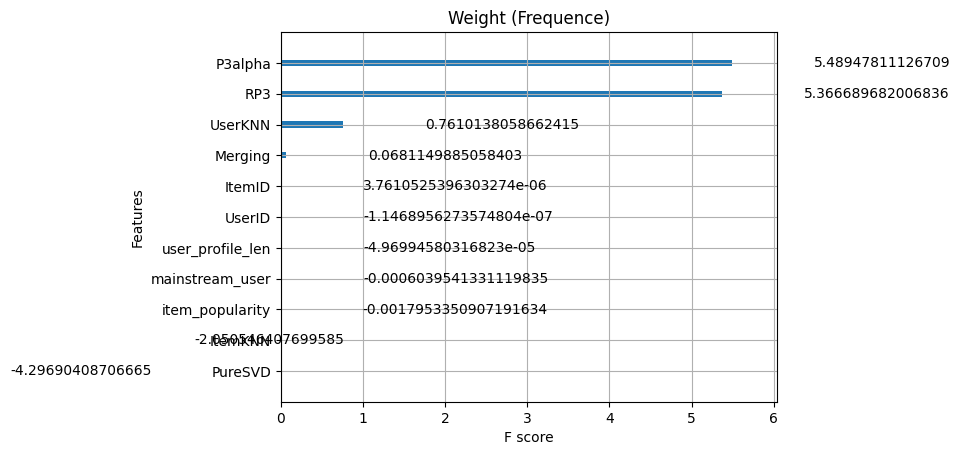

In [51]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [52]:
pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=10)
user_factors_prediction = pure_svd.USER_factors

recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_all, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_all, [recommender_item, recommender_rp3, recommender_p3a], weights)

PureSVDRecommender: URM Detected 851 ( 6.5%) users with no interactions.
PureSVDRecommender: URM Detected 476 ( 2.1%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.23 sec
ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4281.39 column/sec. Elapsed time 5.22 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2368.80 column/sec. Elapsed time 9.43 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2810.00 column/sec. Elapsed time 7.95 sec
ItemKNNSimilarityHybridRe

In [53]:
cutoff = 30
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    prediction_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'PureSVD'] = pure_svd._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    prediction_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

# user_factors_df = pd.DataFrame(user_factors_prediction, columns=[f'factor_{i}' for i in range(user_factors_train.shape[1])])

# prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3799021474.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3799021474.py:13: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,UserKNN,RP3,P3alpha,PureSVD,Merging,ItemKNN,item_popularity,user_profile_len,mainstream_user
0,0,35,3.245894,0.582968,0.547170,0.172235,0.735422,1.034604,713,44,157.795455
1,0,100,2.917171,0.504033,0.412977,0.098410,0.690468,1.056338,426,44,157.795455
2,0,402,1.204698,0.293038,0.181247,0.032064,0.432134,0.705102,131,44,157.795455
3,0,505,1.330598,0.227102,0.132908,0.033177,0.320689,0.504349,119,44,157.795455
4,0,514,1.116114,0.221572,0.107178,0.023935,0.313993,0.495366,97,44,157.795455
...,...,...,...,...,...,...,...,...,...,...,...
390715,13023,2236,0.441869,0.133758,0.091180,0.001602,0.269168,0.534904,37,71,147.563380
390716,13023,623,0.492786,0.134283,0.103094,0.018290,0.253764,0.488237,99,71,147.563380
390717,13023,705,0.239898,0.136817,0.107493,0.004991,0.248729,0.468351,110,71,147.563380
390718,13023,836,0.224060,0.145385,0.086341,0.002991,0.246191,0.444019,94,71,147.563380


In [54]:
recommender = TmpRecommender(URM_all, XGB_model, prediction_dataframe)

In [55]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,637 318 694 1546 515 506 403 123 101 36
1,2,2 11 359 131 12 50 28 1095 196 47
2,3,1231 648 239 511 750 857 970 986 450 4252
3,4,136 314 187 57 254 7 145 249 50 28
4,5,10150 7033 13064 2706 8664 5138 1220 1285 1570...
